This notebook does basic analysis on images from SIDD Small dataset (on SRGB images)

In [73]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as compare_ssim

Noisy image


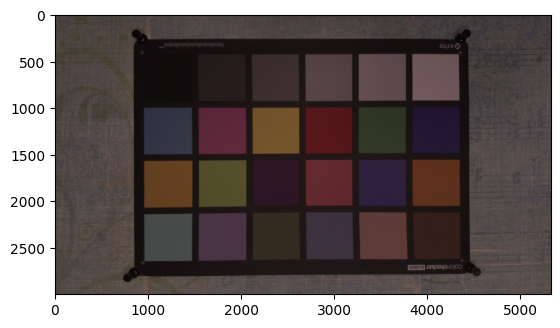

Ground truth image


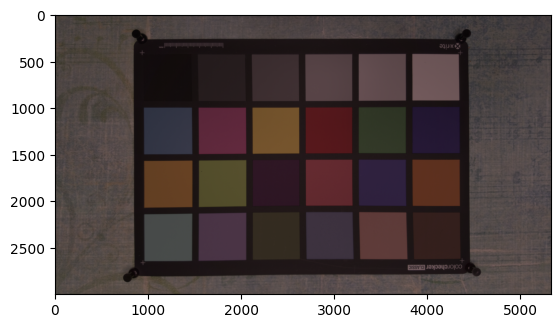

In [74]:
noisy_image = cv2.imread('../data/0001_001_S6_00100_00060_3200_L/NOISY_SRGB_010.PNG')
noisy_image = cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB)

print('Noisy image')
plt.imshow(noisy_image)
plt.show()

gt_image = cv2.imread('../data/0001_001_S6_00100_00060_3200_L/GT_SRGB_010.PNG')
gt_image = cv2.cvtColor(gt_image, cv2.COLOR_BGR2RGB)

print('Ground truth image')
plt.imshow(gt_image)
plt.show()

In [75]:

# Analysis of image dimensions
print('shape = ', noisy_image.shape)

def get_basic_metrics(image, title, gt_image):
    r, g, b = cv2.split(image)
    max_r = np.max(r)
    max_g = np.max(g)
    max_b = np.max(b)

    print('for image ', title, end='\n')
    print(f'Maximum Red Value: {max_r}')
    print(f'Maximum Green Value: {max_g}')
    print(f'Maximum Blue Value: {max_b}')

    print('max value', np.max(gt_image), np.max(noisy_image))
    print('psnr  = ', cv2.PSNR(gt_image, image))
    print('ssim = ', compare_ssim(image, gt_image, multichannel=True, channel_axis=2))
    print('\n')
    
get_basic_metrics(noisy_image, 'noisy image', gt_image)
get_basic_metrics(gt_image, 'ground truth image', gt_image)

shape =  (3000, 5328, 3)
for image  noisy image
Maximum Red Value: 139
Maximum Green Value: 107
Maximum Blue Value: 121
max value 120 139
psnr  =  31.36859571959388
ssim =  0.6386504685077419


for image  ground truth image
Maximum Red Value: 120
Maximum Green Value: 97
Maximum Blue Value: 100
max value 120 139
psnr  =  361.20199909921956
ssim =  1.0




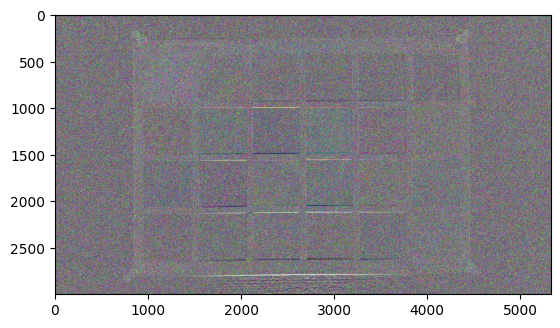

In [76]:
# Image difference (i.e the noise)
# noisy image = gt + noise
# noise = noisy_image - gt
plt.imshow(noisy_image - gt_image)

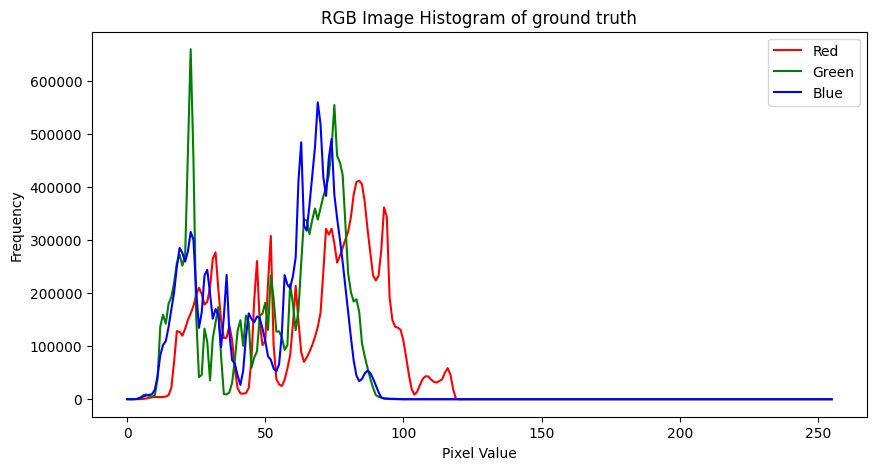

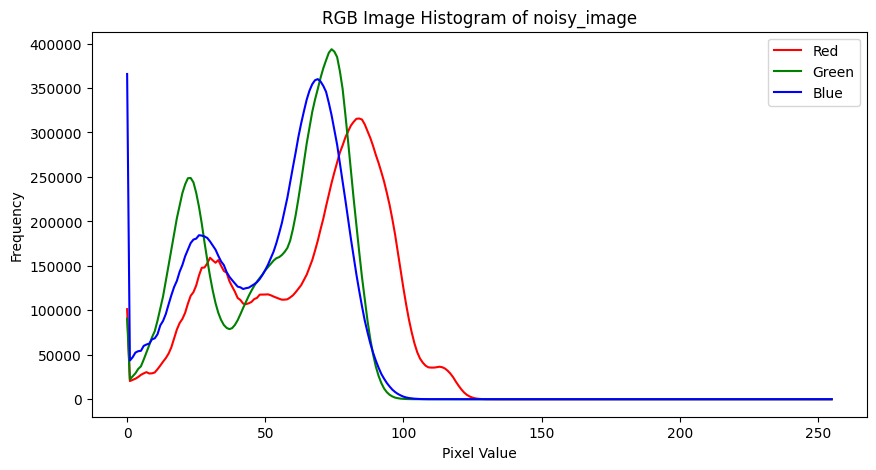

In [77]:
# Histogram analysis
def calc_and_plot_histogram(image, title):

    r, g, b = cv2.split(image)

    hist_r, bins_r = np.histogram(r, bins=256, range=(0, 256))
    hist_g, bins_g = np.histogram(g, bins=256, range=(0, 256))
    hist_b, bins_b = np.histogram(b, bins=256, range=(0, 256))

    # Plot the histograms
    plt.figure(figsize=(10, 5))
    plt.title('RGB Image Histogram of ' + title)
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.plot(bins_r[:-1], hist_r, color='red', label='Red')
    plt.plot(bins_g[:-1], hist_g, color='green', label='Green')
    plt.plot(bins_b[:-1], hist_b, color='blue', label='Blue')
    plt.legend()
    plt.show()
    
calc_and_plot_histogram(gt_image, 'ground truth')
calc_and_plot_histogram(noisy_image, 'noisy_image')

In [99]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


Performing image segmentation (Mobilenet for speed purposes)

In [91]:
import cv2
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
import numpy as np

base_model = MobileNetV2(
        input_shape=(3000, 5328, 3),
        include_top=False,
        weights="imagenet"
    )

x = base_model.output
x = Conv2D(21, (1, 1), activation='softmax')(x)
x = Conv2DTranspose(21, (4, 4), strides=(2, 2), padding='same')(x)

segmentation_model = tf.keras.Model(inputs=base_model.input, outputs=x)

actual image


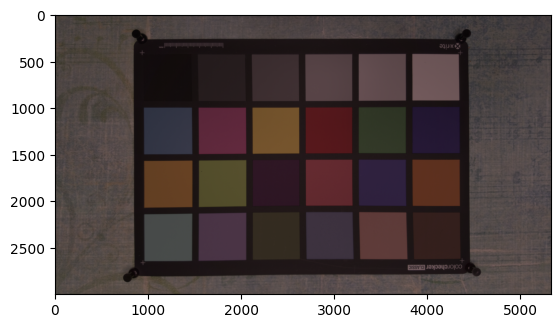

../data/0001_001_S6_00100_00060_3200_L/GT_SRGB_010.PNG


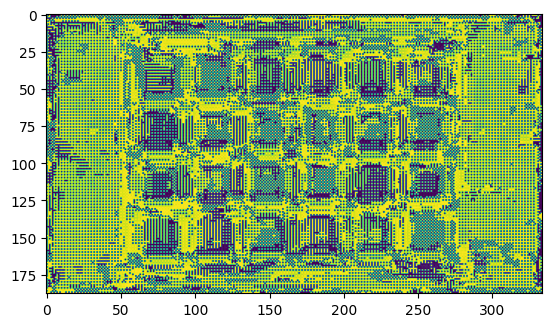

../data/0001_001_S6_00100_00060_3200_L/NOISY_SRGB_010.PNG


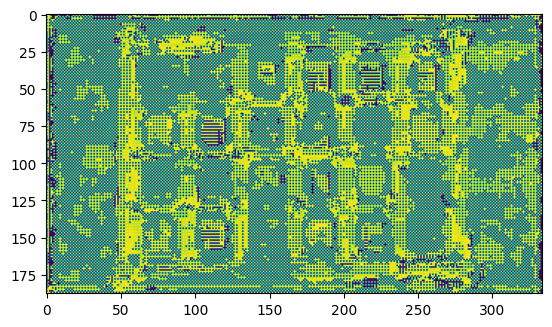

In [98]:
def real_time_segmentation(image_path):
    input_shape = (3000, 5328, 3)  
    
    frame = cv2.imread(image_path)
    frame = frame / 255.0  

    segmentation_result = segmentation_model.predict(np.expand_dims(frame, axis=0))

    mask = segmentation_result[0, :, :, 0] 
    mask = (mask * 255).astype(np.uint8)
    print(image_path)
    plt.imshow(mask)  
    plt.show()

print('actual image')
plt.imshow(gt_image)
plt.show()

real_time_segmentation('../data/0001_001_S6_00100_00060_3200_L/GT_SRGB_010.PNG')
real_time_segmentation('../data/0001_001_S6_00100_00060_3200_L/NOISY_SRGB_010.PNG')